# Spline Collocation Methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def B0(x,x0=0,x1=1):
    return (x>=x0)*(x<x1)


pts=np.linspace(-2,2,100)
plt.plot(pts,B0(pts))


def Brecur(x,i,knot,degree):  
    #x is where I evaluate the splie
    #knot is vector of t_i locations
    #i is knot basis function
    if degree==0: #no recursion
        return B0(x,knot[i],knot[i+1])
    else:
        fac1=(x-knot[i])/(knot[i+degree]-knot[i])
        fac2=(knot[i+degree+1]-x)/(knot[i+degree+1]-knot[i+1])
        return fac1*Brecur(x,i,knot,degree-1)+fac2*Brecur(x,i+1,knot,degree-1)
    
#spline derivatives
def dB(x,i,knot,degree):
    if degree==0:
        return np.zeros(x.shape())
    else:
        temp=degree/(knot[i+degree]-knot[i])*Brecur(x,i,knot,degree-1)
        temp-=degree/(knot[i+degree+1]-knot[i+1])*Brecur(x,i+1,knot,degree-1)
        return temp
    
def d2B(x,i,knot,degree):
    if degree<=1:
        return np.zeros(x.shape())
    else:
        temp=degree/(knot[i+degree]-knot[i])*dB(x,i,knot,degree-1)
        temp-=degree/(knot[i+degree+1]-knot[i+1])*dB(x,i+1,knot,degree-1)
        return temp


I will **shift** our usual spline basis functions so that the support is centered.
Note that with integer knots beforehand, $B_0$ had support on [0,4].  I will reindex the function so that $B_2$ is the same basis function, with support on [0,4].

I plot $B_2$ and $B_2^{\prime\prime}$ below:

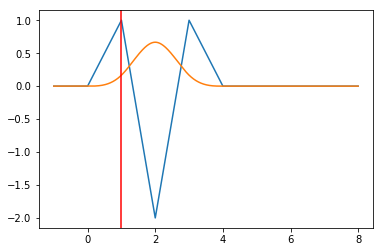

In [39]:
knot=np.arange(10)
degree=3
plt.figure()
x=np.linspace(-1,8,1000)
for i in range(1):
    B=Brecur(x,i,knot,degree)
    derB=dB(x,i,knot,degree)
    #plt.plot(x,derB)
    derB2=d2B(x,i,knot,degree)
    plt.plot(x,derB2)
    plt.plot(x,B)
plt.axvline(1,c='r')
plt.show()

Say I want to solve $-u^{\prime\prime}=\sin \pi x$, $u(0)=u(1)=0$, using collocation.

I allocate $n$ points (zero-indexed) between $0$ and $1$ inclusive.  These will be my spline knots.
With the new indexing, $B_{-1}$ and $B_{n}$ will also have support in $(0,1)$

At collocation point $x_i$, the equations collapse down to 
$$-(B_{i}^{\prime\prime}(x_i)+B_{i-1}^{\prime\prime}(x_i)+B_{i+1}^{\prime\prime}(x_i)) = f(x_i)$$
Note that the second derivatives of $B_{i-2}$ and $B_{i+2}$ are zero at $x_i$, and all other basis-functions are not in the support.

We also get two other equations, related to the boundary conditions.  This requires that
$B_{-1}+B_{0}+B_{1}=0$, and $B_{n-2}+B_{n-1}+B_{n}=0$.

Let's plot the basis functions that we are using with 9 grid points, i.e. $h=1/8$.

In [12]:
n=9
grid=np.linspace(0,1,n) #n knots
h=grid[1]-grid[0]
knot=np.arange(-3*h,1+6*h,h)
print(knot)

[-0.375 -0.25  -0.125  0.     0.125  0.25   0.375  0.5    0.625  0.75
  0.875  1.     1.125  1.25   1.375  1.5    1.625]


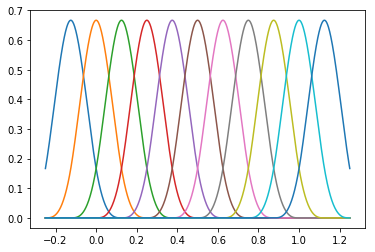

In [15]:
degree=3
pt=np.linspace(-.25,1.25,1000)
for i in range(0,knot.size-6):
    B=Brecur(pt,i,knot,3)
    plt.plot(pt,B)
plt.show()

In [31]:
# now build the collocation matrix:

# 11 basis functions, so 11x11 matrix.

def rhs(x):
    return np.sin(np.pi*x)

C=np.zeros((11,11))
b=np.zeros(11)
b[1:-1]=rhs(grid)
print(b)
for i in range(grid.size+2):
    C[1:-1,i]=-d2B(grid,i,knot,3)
    C[0,i]=Brecur(0,i,knot,3)
    C[-1:,i]=Brecur(1,i,knot,3)
print(C)
d=np.ones(11) 
d[1:-1]=1/8**2
D=np.diag(d)
print(np.dot(D,C))
         

[  0.00000000e+00   0.00000000e+00   3.82683432e-01   7.07106781e-01
   9.23879533e-01   1.00000000e+00   9.23879533e-01   7.07106781e-01
   3.82683432e-01   1.22464680e-16   0.00000000e+00]
[[   0.16666667    0.66666667    0.16666667    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ -64.          128.          -64.           -0.           -0.           -0.
    -0.           -0.           -0.           -0.           -0.        ]
 [  -0.          -64.          128.          -64.           -0.           -0.
    -0.           -0.           -0.           -0.           -0.        ]
 [  -0.           -0.          -64.          128.          -64.           -0.
    -0.           -0.           -0.           -0.           -0.        ]
 [  -0.           -0.           -0.          -64.          128.          -64.
    -0.           -0.           -0.           -0.           -0.        ]
 [  -0.           -0.           -0.           -0.     

In [27]:
sol=np.linalg.solve(C,b)
print(sol)

[ -3.92760898e-02  -1.38777878e-17   3.92760898e-02   7.25727509e-02
   9.48208686e-02   1.02633369e-01   9.48208686e-02   7.25727509e-02
   3.92760898e-02   0.00000000e+00  -3.92760898e-02]


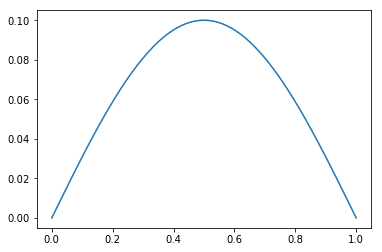

[  0.00000000e+00   0.00000000e+00   3.82683432e-01   7.07106781e-01
   9.23879533e-01   1.00000000e+00   9.23879533e-01   7.07106781e-01
   3.82683432e-01   1.22464680e-16   0.00000000e+00]


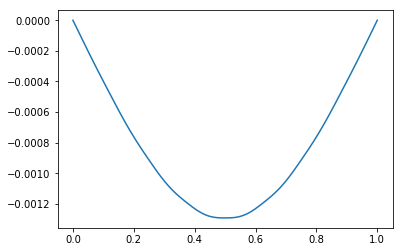

In [36]:
#plot the solution
pts=np.linspace(0,1,1000)
usol=np.zeros(pts.size)
for i in range(0,grid.size+2):
    usol+=sol[i]*Brecur(pts,i,knot,degree)
plt.plot(pts,usol)
plt.show()
print(b)
#error plot
plt.plot(pts,usol-1.0/np.pi**2*np.sin(np.pi*pts))
plt.show()

The matrix is very similar to the matrix for a finite difference approximation.  In fact, with a little algebra, (and assumptions on the data $f$), we can show that we get exactly the same matrix as the finite difference approximation.

In some sense, we are making a linear approximation to $u^{\prime\prime}$ if we are taking cubic basis functions for the derivative.